# Hyper-parameter optimization using HyperOpt and nested runs in MLflow

This notebook demonstrates how to use MLflow for tracking experiment using MLflow in Azure ML when you want to do hyper-parameter optimization using child runs. In MLflow a run can start child runs which will get logged inside of it. This is useful when doing hyper-parameters cause you can get one dedicated run for each trial, while keeping all the runs controlled by a parent run which orchestrates the parameters search. 

In this example we will show also how you can get artifacts from the child run and log them inside of the parent. We are going to use the library `HyperOpt` for doing the optimization.

> **Important:** You may also want to explore using the parameter sweep component from Azure ML for doing hyper-parameter optimization in job-based runs. Check [CLI (v2) sweep job](https://docs.microsoft.com/en-us/azure/machine-learning/reference-yaml-job-sweephttps://docs.microsoft.com/en-us/azure/machine-learning/reference-yaml-job-sweep) for more details.

In [ ]:
# Ensure you have the dependencies for this notebook
%pip install -r xgboost_nested_runs.txt

In [2]:
import warnings

warnings.simplefilter("ignore")

## Configuring the experiment

Let's get started. It's always a good idea to start by configuring the name of the experiment we are working with in MLflow. Experiments allows you to organize runs in a comprehensive way so you can compare different experiment's runs with different parameters and configuration. MLflow configures the default experiment named "Default" but you can change this name.

In [3]:
import mlflow

mlflow.set_experiment(experiment_name="heart-condition-classifier")

<Experiment: artifact_location='', experiment_id='368f3886-e4e3-449a-bd1e-593c5b0e01ff', lifecycle_stage='active', name='heart-condition-classifier', tags={}>

## Exploring the data

In [4]:
import pandas as pd

In [5]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

In [6]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,52,1,1,118,186,0,2,190,0,0.0,2,0,fixed,0
299,43,0,4,132,341,1,2,136,1,3.0,2,0,reversible,1
300,65,1,4,135,254,0,2,127,0,2.8,2,1,reversible,1
301,48,1,4,130,256,1,2,150,1,0.0,1,2,reversible,1


As we can see, some of the variables are categorical. To make it simpler for our model to handle these values, let's use their encoded values:

In [7]:
df["thal"] = df["thal"].astype("category").cat.codes

The encoded values looks then as follows:

In [8]:
df["thal"].unique()

array([2, 3, 4, 0, 1], dtype=int8)

Let's split our dataset in train and test, so we can assess the performance of the model without overfitting the dataset.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("target", axis=1), df["target"], test_size=0.3
)

### Defining the search space

Since we are going to do hyper-parameter optimization, we need to define the search space we are going to use for each parameter. In this simple example, we are optimizing the following parameters:

In [10]:
from hyperopt import hp

space = {
    "learning_rate": hp.uniform("learning_rate", 1e-5, 1e-1),
    "max_leaves": hp.choice("max_leaves ", options=[2, 5, 9, 10, 20, 30]),
}

## Training a model

We are going to place all the training code inside of a function so we can use for searching the best parameters configuration. HyperOpt requires us to have **the first positional parameter of this function to receive the parameters of each trial**. Here we are placing them in an argument called `params` which is a dictionary. The rest of the parameters needs to be named parameters. You need to comply with this convention.

The function needs to return either a float value which correspond to the loss of the trial, or a dictionary which specific keys. Read the documentation of HyperOpt for other options and details. We are using the dictionary option here cause we want to return some extra information about each trial which is the run ID in MLflow corresponding to the trial. Pay attention how this is indicated in a key `attachments`. This will be handy later to download assets for each run.

It's worth noticing how the MLflow run is started with the parameter `nested=True`. This indicates to MLflow that the current run is a child run of a higher level one. The parent run controls the parameter optimization while each child focus on training one particular model. Also, notice how we are using `autolog` to log metrics, parameters and models automatically for us.

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_curve, auc
from typing import Any, Dict
from hyperopt import STATUS_OK


def train(
    params: Dict[str, Any], X_train: pd.DataFrame, X_test, y_train: pd.DataFrame, y_test
) -> Dict[str, Any]:
    run_name = "_".join(params.keys())
    with mlflow.start_run(nested=True, run_name=f"hyperopt_{run_name}") as child_run:
        # Using autolog for xgboost model
        mlflow.xgboost.autolog(silent=True)

        # Using autolog for the metrics calculated with scikit-learn
        mlflow.sklearn.autolog(silent=True)

        model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", **params)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        y_pred = model.predict(X_test)

        # Calculate some metrics
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=2)
        auc_metric = auc(fpr, tpr)

        # Return a dictionary HyperOpt can use to better inform the search
        # We are also returning the run_id of each iteration so we can use it
        # later to access the best run from Mlflow.
        return {
            "status": STATUS_OK,
            "loss": -recall,
            "attachments": {"run_id": child_run.info.run_id},
        }

### Creating a search function

We are going to create a search function for doing the hyper-parameter optimization. This is not required -  you can place all the code directly on notebook's cells but it is a good choice. The function will:

1. Start a new MLflow run to do the optimization this parent run is the one in charge of doing the overall optimization. Notice that if you are running inside of an AML job, you are should not start the run manually cause it is already done for you.
2. Creates a `fmin` object which will do the optimization using HyperOpt.
3. Gets the best trial and best run ID from MLflow.
4. Downloads the best model from the child run which was better and register it in the parent run.
5. Logs the best child run in the parent run along with the best hyper-parameters configuration we found.
6. Logs some extra artifacts (see details later).

In [12]:
import hyperopt.plotting
from hyperopt import fmin, tpe, rand, Trials
from functools import partial
from matplotlib import pyplot as plt


def search(
    space: Dict[str, Any], X_train: pd.DataFrame, X_test, y_train: pd.DataFrame, y_test
):
    with mlflow.start_run() as run:
        print("Working in MLflow run:", run.info.run_id)
        trials = Trials()
        best_params = fmin(
            fn=partial(
                train, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
            ),
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials,
        )
        best_run_id = trials.trial_attachments(trials.best_trial)["run_id"]
        best_run = mlflow.get_run(best_run_id)

        client = mlflow.tracking.MlflowClient()
        best_model = client.download_artifacts(best_run_id, path="model")

        mlflow.log_param("best_run_id", best_run_id)
        mlflow.log_params({f"best_{p}": v for p, v in best_params.items()})
        mlflow.log_metric("best_loss", trials.best_trial["result"]["loss"])
        mlflow.log_artifacts(local_dir=best_model, artifact_path="model")

        fig = plt.figure()
        ax = fig.add_subplot()
        hyperopt.plotting.main_plot_histogram(trials, do_show=False)
        mlflow.log_figure(fig, "loss_histogram.png")

        return trials, best_params

Some things to notice about `fmin`:
- `fmin` is used to minimize the loss according to the objective indicated in the function `train`. If you pay closer look at how it is indicated, we wrapped the function with `partial`. This is because the function receives extra parameters we are not looking to optimize, but they are directly passed to the function. We are passing here the train and test splits for the features and labels.
- `algo` is indicated with `tpe.suggest`, meaning that we are relying on HyperOpt to guess which is the best algorithm to use based on the space we are using.
- `max_evals` indicates how many trials will be executed. We are not using early termination in this example, but you are welcome to explore it.
- `trials` is passed to the `fmin` function. This is not required but when the argument is present, all the debug information about the trials is stored there. It's a best practice to always indicate it.

Some things to notice in the `search` function:
- The function `fmin` returns the best parameters combination, but it doesn't provide information about which is the best run. For that, we use `trials.best_trial`. We also added `run_id` as an attachment, so we can use it to get the best run inside of MLflow. This is convenient because we don't have to query all the child runs to guess which is the best one.
- We are downloading the best model so we can log it in the parent run. This is done using the function `client.download_artifacts` for the child run and then `mlflow.log_artifacts` for the parent run. So the best model is logged twice, inside of the parent run and also inside of the child run that generated it.
- For further reference, the best run ID is also logged as a parameters with the method `mlflow.log_param`.
- HyperOpt also has some features for plotting the results. We are logging this plots using `mlflow.log_figure` which will store these plots as `png` files automatically for us.

Let's run the search:

Working in MLflow run: 7eca10a6-d166-4714-a251-10f1585eb101
100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [01:05<00:00, 13.15s/trial, best loss: -0.6]
Showing Histogram of 5 jobs


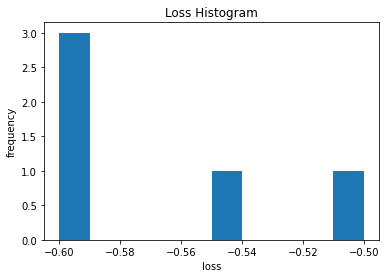

In [13]:
trials, best_params = search(space, X_train, X_test, y_train, y_test)

## Exploring the results in Azure ML

### Using Studio

When child runs are used, they are displayed inside of the experiment's run in the tab `child jobs`:

![](assets/hyperopt_child_runs.png)

You can then view any of the child runs we created and explore metrics, parameters and more:

![](assets/hyperopt_child.png)

### Exploring child runs programmatically

We can also access the runs programmatically using MLflow client:

In [17]:
hyperopt_run = mlflow.last_active_run()

We can see all the child runs by using the tag `mlflow.parentRunId` that gets automatically populated by MLflow and Azure ML.

In [19]:
child_runs = mlflow.search_runs(
    filter_string=f"tags.mlflow.parentRunId='{hyperopt_run.info.run_id}'"
)
child_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.validation_0-logloss,params.max_depth,params.tree_method,params.sampling_method,...,params.n_jobs,params.learning_rate,params.num_boost_round,params.verbosity,tags.mlflow.source.type,tags.mlflow.parentRunId,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.rootRunId,tags.mlflow.source.name
0,a2f4c25f-a296-4e9b-8379-aff302f87a0b,368f3886-e4e3-449a-bd1e-593c5b0e01ff,FINISHED,,2022-06-02 20:38:33.291000+00:00,2022-06-02 20:38:49.621000+00:00,0.317279,None,None,None,...,None,0.037245679920859816,100,None,LOCAL,7eca10a6-d166-4714-a251-10f1585eb101,Facundo Santiago,hyperopt_learning_rate_max_leaves,7eca10a6-d166-4714-a251-10f1585eb101,/home/santiagxf/miniconda3/envs/heart/lib/pyth...
1,27e1ce12-3cef-496a-a1d7-3142cc840566,368f3886-e4e3-449a-bd1e-593c5b0e01ff,FINISHED,,2022-06-02 20:38:50.130000+00:00,2022-06-02 20:39:00.107000+00:00,0.313064,None,None,None,...,None,0.03889419749417589,100,None,LOCAL,7eca10a6-d166-4714-a251-10f1585eb101,Facundo Santiago,hyperopt_learning_rate_max_leaves,7eca10a6-d166-4714-a251-10f1585eb101,/home/santiagxf/miniconda3/envs/heart/lib/pyth...
2,62a991d2-d750-4870-b442-8665ba56c25e,368f3886-e4e3-449a-bd1e-593c5b0e01ff,FINISHED,,2022-06-02 20:39:01.233000+00:00,2022-06-02 20:39:13.467000+00:00,0.327712,None,None,None,...,None,0.025487895466987924,100,None,LOCAL,7eca10a6-d166-4714-a251-10f1585eb101,Facundo Santiago,hyperopt_learning_rate_max_leaves,7eca10a6-d166-4714-a251-10f1585eb101,/home/santiagxf/miniconda3/envs/heart/lib/pyth...
3,07488ee9-b5f4-4450-beab-8f5811bb0d9f,368f3886-e4e3-449a-bd1e-593c5b0e01ff,FINISHED,,2022-06-02 20:39:15.368000+00:00,2022-06-02 20:39:26.214000+00:00,0.324261,None,None,None,...,None,0.05037740245177806,100,None,LOCAL,7eca10a6-d166-4714-a251-10f1585eb101,Facundo Santiago,hyperopt_learning_rate_max_leaves,7eca10a6-d166-4714-a251-10f1585eb101,/home/santiagxf/miniconda3/envs/heart/lib/pyth...
4,e0e59c05-8d34-445d-99dc-9dd60c08a8a0,368f3886-e4e3-449a-bd1e-593c5b0e01ff,FINISHED,,2022-06-02 20:39:26.687000+00:00,2022-06-02 20:39:38.601000+00:00,0.321945,None,None,None,...,None,0.05117885217699967,100,None,LOCAL,7eca10a6-d166-4714-a251-10f1585eb101,Facundo Santiago,hyperopt_learning_rate_max_leaves,7eca10a6-d166-4714-a251-10f1585eb101,/home/santiagxf/miniconda3/envs/heart/lib/pyth...
